<font size="+3"><strong>8.3. Predicting Volatility</strong></font>

In the last lesson, we learned that one characteristic of stocks that's important to investors is **volatility**. Actually, it's so important that there are several time series models for predicting it. In this lesson, we'll build one such model called **GARCH**. We'll also continue working with assert statements to test our code. 

In [2]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


c:\Users\Danjuma Ahmed H\miniconda3\Lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


# Prepare Data

As always, the first thing we need to do is connect to our data source.

## Import 

**Task 8.3.1:** Create a connection to your database and then instantiate a `SQLRepository` named `repo` to interact with that database.

In [3]:
connection = sqlite3.connect(settings.db_name,  check_same_thread = False)
repo = SQLRepository(connection = connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


**Task 8.3.2:** Pull the most recent 2,500 rows of data for Ambuja Cement from your database. Assign the results to the variable `df_ambuja`.

- [Inspect a DataFrame using shape, info, and head in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Inspecting-DataFrames)

In [4]:
df_ambuja = repo.read_table(table_name = "AMBUJACEM.BSE", limit = 2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2023-11-29,434.05,437.10,428.15,435.55,354642.0
2023-11-28,415.65,435.40,415.65,431.20,255414.0
2023-11-24,414.85,415.55,411.35,413.75,90573.0
2023-11-23,414.40,416.75,408.60,415.50,93005.0
2023-11-22,419.15,420.85,413.15,414.30,38283.0


To train our model, the only data we need are the daily returns for `"AMBUJACEM.BSE"`. We learned how to calculate returns in the last lesson, but now let's formalize that process with a wrangle function.

**Task 8.3.3:** Create a `wrangle_data` function whose output is the returns for a stock stored in your database. Use the docstring as a guide and the assert statements in the following code block to test your function. 

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [Write a function in Python.](../%40textbook/02-python-advanced.ipynb#Functions)

In [5]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    tab = repo.read_table(table_name = ticker, limit = n_observations + 1)


    # Sort DataFrame ascending by date
    tab = tab.sort_index(ascending = True)


    # Create "return" column
    tab["return"] = tab["close"].pct_change() * 100

    # Return returns
    return tab["return"].dropna()

When you run the cell below to test your function, you'll also create a Series `y_ambuja` that we'll use to train our model.

In [6]:
y_ambuja = wrangle_data(ticker="AMBUJACEM.BSE", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_ambuja, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_ambuja) == 2500

# Is `y_ambuja` name "return"?
assert y_ambuja.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_ambuja.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_ambuja.index == y_ambuja.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_ambuja.isnull().sum() == 0

y_ambuja.head()

date
2013-09-30   -0.677874
2013-10-01   -1.610702
2013-10-03    5.688124
2013-10-04   -0.498819
2013-10-07    1.503958
Name: return, dtype: float64

Great work! Now that we've got a wrangle function, let's get the returns for Suzlon Energy, too.

**Task 8.3.4:** Use your `wrangle_data` function to get the returns for the 2,500 most recent trading days of Suzlon Energy. Assign the results to `y_suzlon`.

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [Write a function in Python.](../%40textbook/02-python-advanced.ipynb#Functions)

In [7]:
y_suzlon = wrangle_data(ticker = "SUZLON.BSE", n_observations = 2500)

print("y_suzlon type:", type(y_suzlon))
print("y_suzlon shape:", y_suzlon.shape)
y_suzlon.head()

y_suzlon type: <class 'pandas.core.series.Series'>
y_suzlon shape: (2500,)


date
2013-10-04   -0.913242
2013-10-07    1.536098
2013-10-08    2.571861
2013-10-09    2.949853
2013-10-10   -0.716332
Name: return, dtype: float64

## Explore

Let's recreate the volatility time series plot we made in the last lesson so that we have a visual aid to talk about what volatility is.

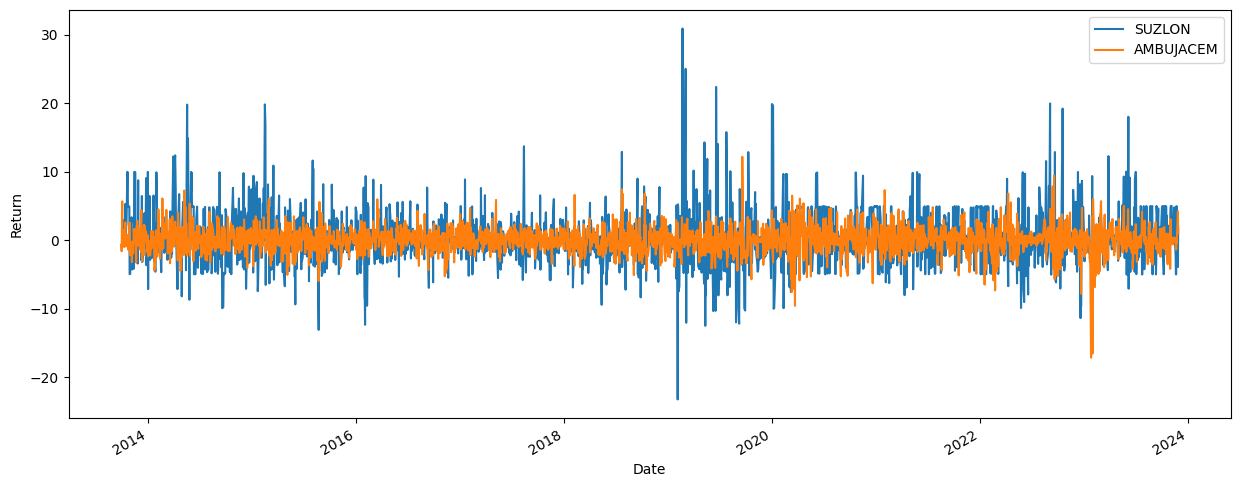

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_suzlon.plot(ax=ax, label="SUZLON")
y_ambuja.plot(ax=ax, label="AMBUJACEM")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The above plot shows how returns change over time. This may seem like a totally new concept, but if we visualize them without considering time, things will start to look familiar.

**Task 8.3.5:** Create a histogram `y_ambuja` with 25 bins. Be sure to label the x-axis `"Returns"`, the y-axis `"Frequency [count]"`, and use the title `"Distribution of Ambuja Cement Daily Returns"`.

- [What's a histogram?](../%40textbook/08-visualization-plotly.ipynb#Histogram)
- [Create a histogram using Matplotlib.](../%40textbook/06-visualization-matplotlib.ipynb#Histograms)

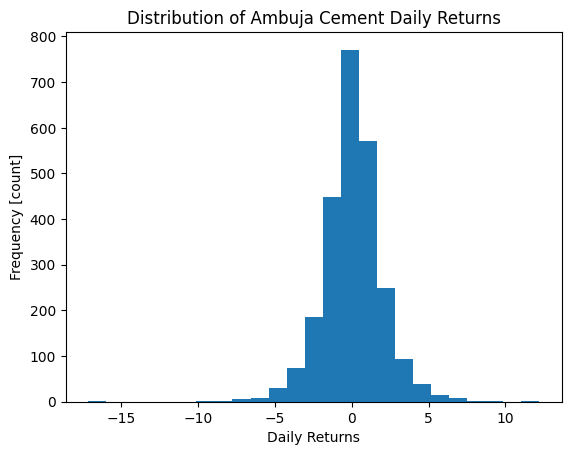

In [9]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(y_ambuja, bins = 25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of Ambuja Cement Daily Returns")
plt.savefig("images/AMBUJACEM-daily-return-hist", dpi=150)

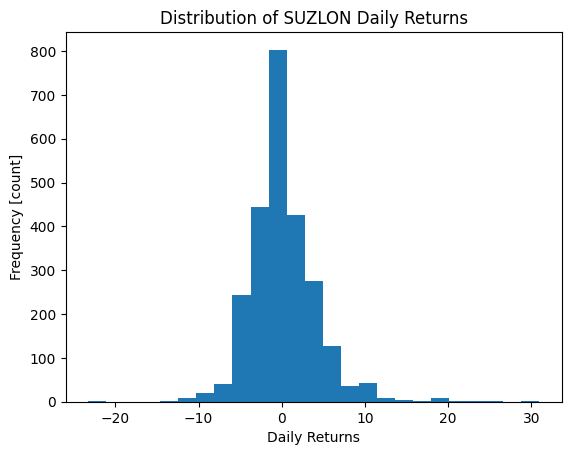

In [10]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(y_suzlon, bins = 25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of SUZLON Daily Returns")
plt.savefig("images/SUZLON-daily-return-hist.png", dpi=150)

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on `0`. **Volatility** is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.

Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

**Task 8.3.6:** Calculate daily volatility for Suzlon and Ambuja, assigning them to the variables `suzlon_daily_volatility` and `ambuja_daily_volatility`, respectively.

- [What's volatility?](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Calculate the volatility for an asset using Python.](../%40textbook/18-ts-models.ipynb#Calculating-Returns)

In [11]:
suzlon_daily_volatility = y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.938240042619196
Ambuja Daily Volatility: 1.9474199415013664


Looks like Suzlon is more volatile than Ambuja. This reinforces what we saw in our time series plot, where Suzlon returns have a much wider spread.

While daily volatility is useful, investors are also interested in volatility over other time periods — like annual volatility. Keep in mind that a year isn't 365 days for a stock market, though. After excluding weekends and holidays, most markets have only 252 trading days.

So how do we go from daily to annual volatility? The same way we calculated the standard deviation for our multi-day experiment in Project 7!

**Task 8.3.7:** Calculate the annual volatility for Suzlon and Ambuja, assigning the results to `suzlon_annual_volatility` and `ambuja_annual_volatility`, respectively.

- [What's volatility?](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Calculate the volatility for an asset using Python.](../%40textbook/18-ts-models.ipynb#Calculating-Returns)

In [12]:
suzlon_annual_volatility = suzlon_daily_volatility * np.sqrt(252)
ambuja_annual_volatility = ambuja_daily_volatility * np.sqrt(252)

print("Suzlon Annual Volatility:", suzlon_annual_volatility)
print("Ambuja Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 62.51762253628085
Ambuja Annual Volatility: 30.914333180523414


Again, Suzlon has higher volatility than Ambuja. What do you think it means that the annual volatility is larger than daily?

Since we're dealing with time series data, another way to look at volatility is by calculating it using a rolling window. We'll do this the same way we calculated the rolling average for PM 2.5 levels in Project 3. Here, we'll start focusing on Ambuja Cement exclusively.

**Task 8.3.8:** Calculate the rolling volatility for `y_ambuja`, using a 50-day window. Assign the result to `ambuja_rolling_50d_volatility`.

- [What's a rolling window?](../%40textbook/17-ts-core.ipynb#Rolling-Averages)
- [Do a rolling window calculation in pandas.](../%40textbook/18-ts-models.ipynb#Making-a-Line-Plot-with-Rolling-Averages)

In [13]:
ambuja_rolling_50d_volatility = y_ambuja.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(ambuja_rolling_50d_volatility))
print("rolling_50d_volatility shape:", ambuja_rolling_50d_volatility.shape)
ambuja_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2013-12-12    1.796394
2013-12-13    1.812090
2013-12-16    1.820709
2013-12-17    1.623720
2013-12-18    1.656767
Name: return, dtype: float64

**Task 8.3.9:** Create a time series plot showing the daily returns for Ambuja Cement and the 50-day rolling volatility. Be sure to label your axes and include a legend.

- [Make a line plot with time series data in pandas.](../%40textbook/18-ts-models.ipynb#Making-a-Line-Plot-with-Rolling-Averages)

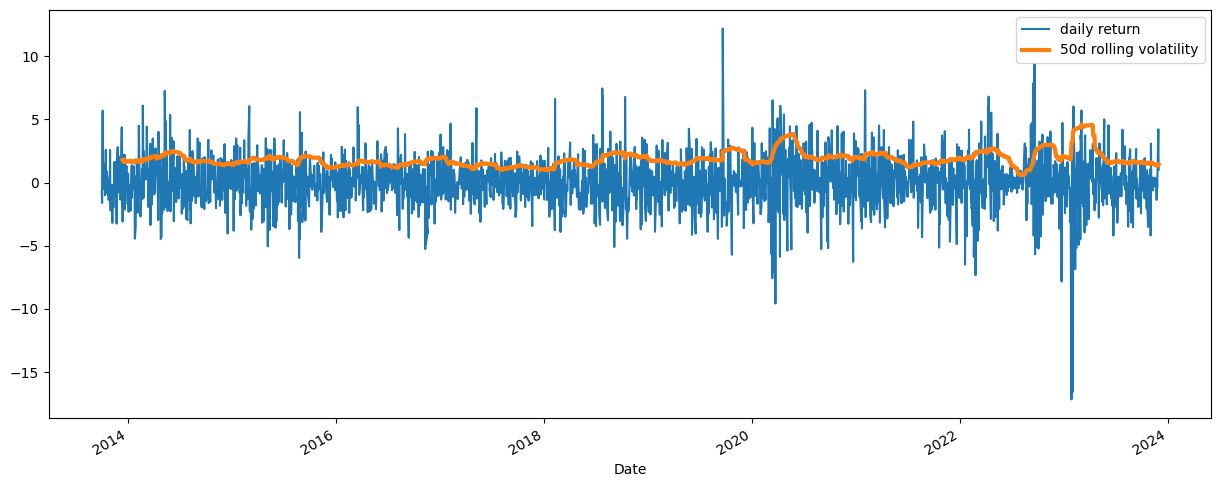

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_ambuja.plot(ax=ax, label = "daily return")

# Plot `ambuja_rolling_50d_volatility`
ambuja_rolling_50d_volatility.plot(ax=ax, label= "50d rolling volatility", linewidth = 3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend()
plt.savefig("images/AMBUJA-rolling-50d-volatility.png", dpi=150);

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.  

**Task 8.3.10:** Create a time series plot of the squared returns in `y_ambuja`. Don't forget to label your axes.

- [Make a line plot with time series data in pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

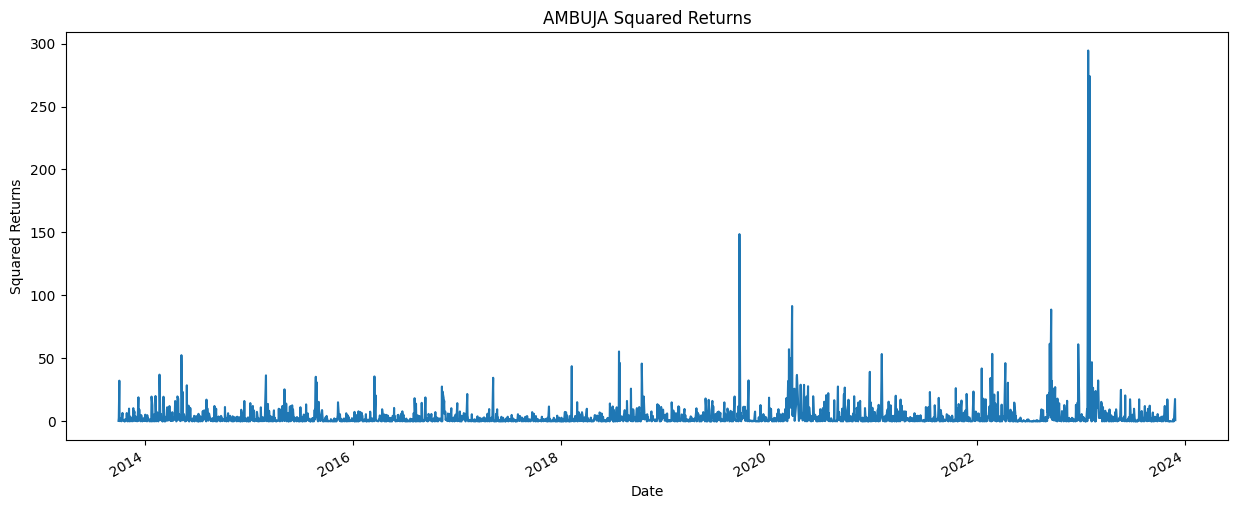

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_ambuja**2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns")
plt.title("AMBUJA Squared Returns");
plt.savefig("images/AMBUJA-squared-returns.png", dpi=150)

Perfect! Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model we learned about in Lesson 3.4. It has a `p` parameter handling correlations at prior time steps and a `q` parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns. 

**Task 8.3.11:** Create an ACF plot of squared returns for Ambuja Cement. Be sure to label your x-axis `"Lag [days]"` and your y-axis `"Correlation Coefficient"`.

- [What's an ACF plot?](../%40textbook/18-ts-models.ipynb#ACF-Plots)
- [Create an ACF plot using statsmodels.](../%40textbook/18-ts-models.ipynb#ACF-Plots)

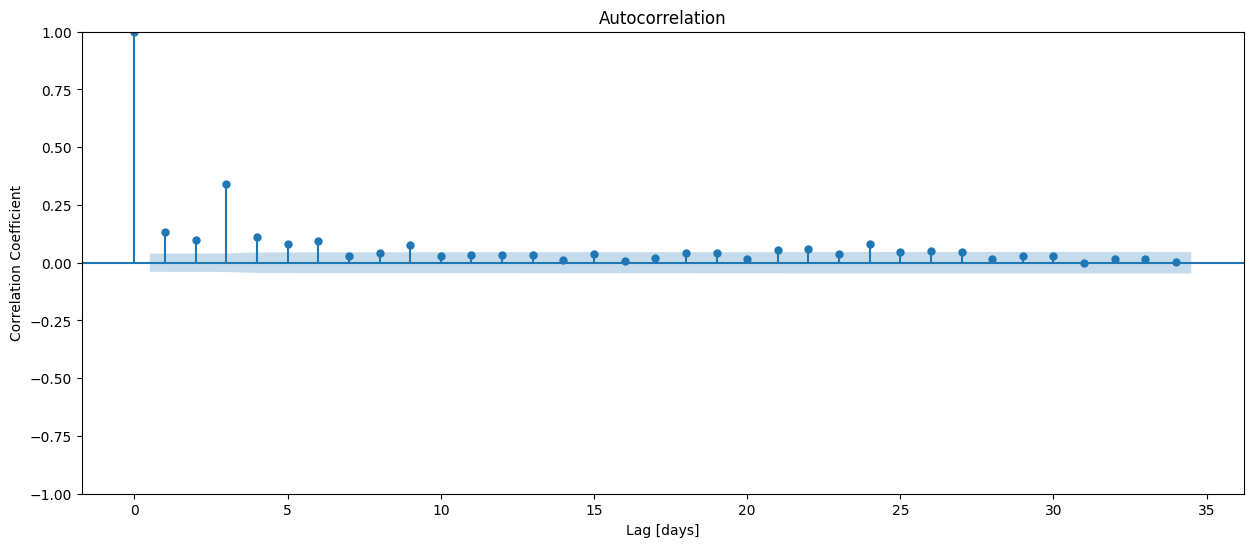

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ambuja**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");


**Task 8.3.12:** Create a PACF plot of squared returns for Ambuja Cement. Be sure to label your x-axis `"Lag [days]"` and your y-axis `"Correlation Coefficient"`.

- [What's a PACF plot?](../%40textbook/18-ts-models.ipynb#Creating-a-PACF-Plot)
- [Create a PACF plot using statsmodels.](../%40textbook/18-ts-models.ipynb#Creating-a-PACF-Plot)

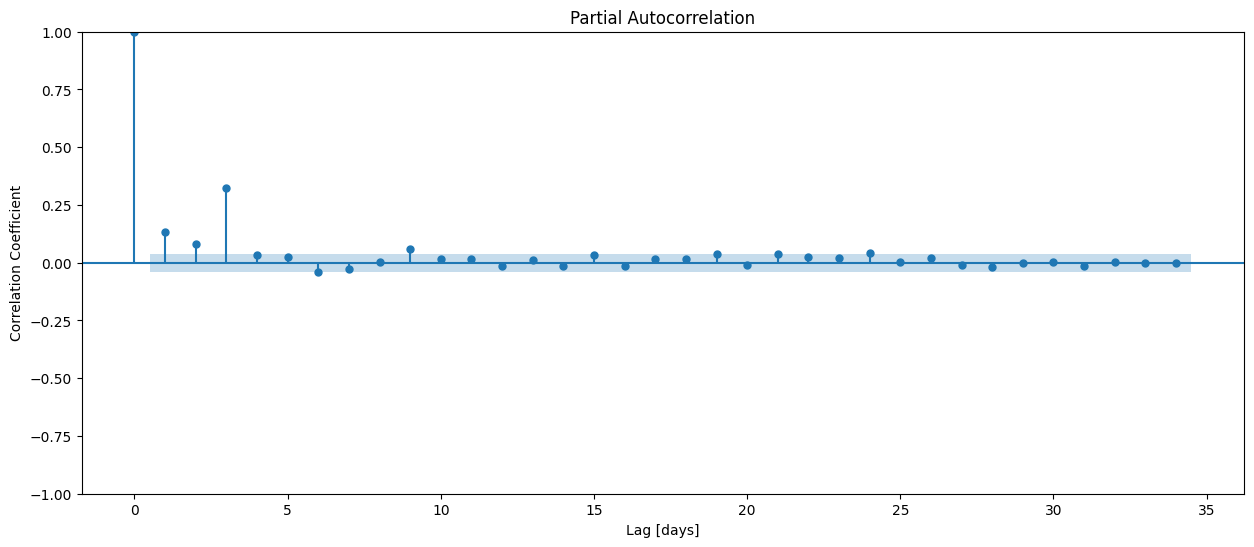

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_ambuja**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");


In our PACF, it looks like a lag of 3 would be a good starting point. 

Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use **returns** to train our model, but we want it to predict **volatility**. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance. So this time, we'll skip right to iterating. 

## Split

The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of `y_ambuja` to conduct walk-forward validation after we've built our model. 

**Task 8.3.13:** Create a training set `y_ambuja_train` that contains the first 80% of the observations in `y_ambuja`. 

In [18]:
cutoff_test = int(len(y_ambuja) * 0.8)
y_ambuja_train = y_ambuja.iloc[:cutoff_test]

print("y_ambuja_train type:", type(y_ambuja_train))
print("y_ambuja_train shape:", y_ambuja_train.shape)
y_ambuja_train.tail()

y_ambuja_train type: <class 'pandas.core.series.Series'>
y_ambuja_train shape: (2000,)


date
2021-11-15   -0.544057
2021-11-16   -2.628137
2021-11-17   -0.036639
2021-11-18   -2.076970
2021-11-22   -2.944479
Name: return, dtype: float64

# Build Model

Just like we did the last time we built a model like this, we'll begin by iterating.

## Iterate

**Task 8.3.14:** Build and fit a GARCH model using the data in `y_ambuja`. Start with `3` as the value for `p` and `q`. Then use the model summary to assess its performance and try other lags.

- [What's a GARCH model?](../%40textbook/18-ts-models.ipynb#ARCH-and-GARCH-Models)
- [What's AIC?](../%40textbook/18-ts-models.ipynb#Common-Metrics)
- [What's BIC?](../%40textbook/18-ts-models.ipynb#Common-Metrics)
- [Build a GARCH model using arch.](../%40textbook/18-ts-models.ipynb#ARCH-and-GARCH-Models)

In [19]:
# Build and train model
model = arch_model(
    y_ambuja_train,
    p = 1,
    q = 1,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3986.25
Distribution:                  Normal   AIC:                           7980.51
Method:            Maximum Likelihood   BIC:                           8002.91
                                        No. Observations:                 2000
Date:                Thu, Nov 30 2023   Df Residuals:                     1999
Time:                        14:57:51   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0722  3.919e-02      1.842  6.549e-02 [-4.628e-03,  0.149]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1645  6.513e-02      2.526  1.154e-02   [3.685e-02,  0.292]
alpha[1]       0.0600  1.473e-02      4.074  4.623e-05 [3.114e-02,8.890e-02]
beta[1]        0.8904  2.967e-02     30.013 6.715e-198     [  0.832,  0.949]
============================================================================

Covariance estimator: robust
"""

Now that we've settled on a model, let's visualize its predictions, together with the Ambuja returns.

**Task 8.3.15:** Create a time series plot with the Ambuja returns and the conditional volatility for your `model`. Be sure to include axis labels and add a legend.

- [Make a line plot with time series data in pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

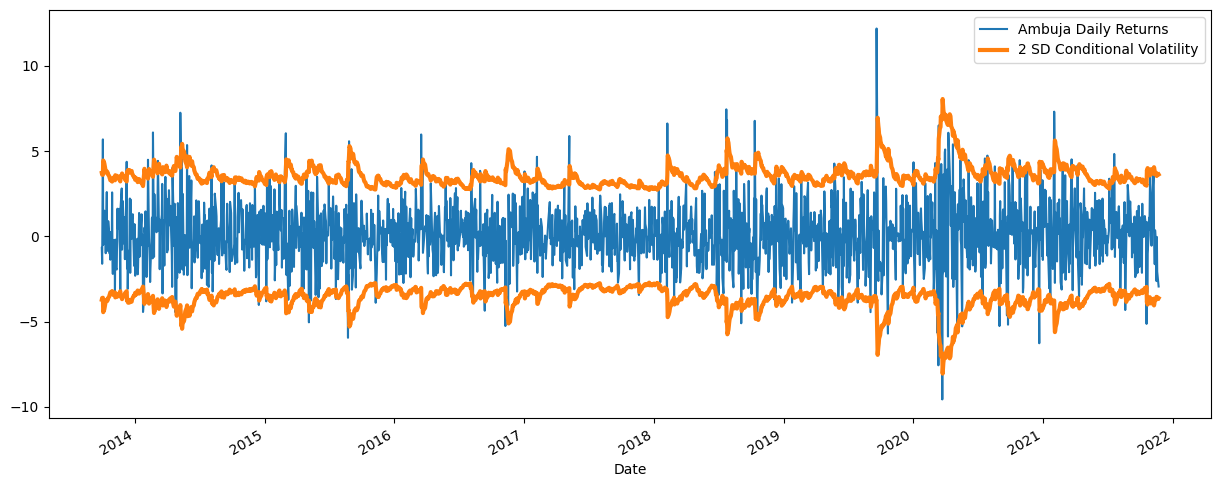

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_ambuja_train.plot(ax=ax, label = "Ambuja Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax= ax,
    color = "C1",
    label = "2 SD Conditional Volatility",
    linewidth = 3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility).rename().plot(
    ax= ax,
    color = "C1",
    linewidth = 3,
    label = ""
)


# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();
plt.savefig("images/AMBUJA-2-volatility.png", dpi=150)

Visually, our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals. 

**Task 8.3.16:** Create a time series plot of the standardized residuals for your `model`. Be sure to include axis labels and a legend.

- [Make a line plot with time series data in pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)
- [What are standardized residuals in a GARCH model?](../%40textbook/18-ts-models.ipynb#Standardized-Residuals)

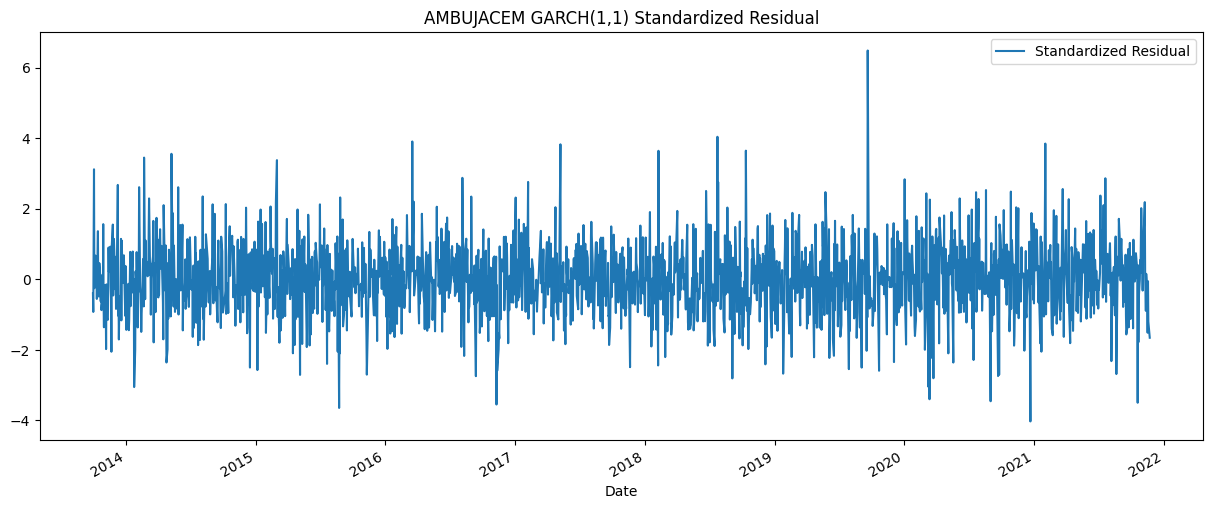

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label = "Standardized Residual")

# Add axis labels
plt.xlabel("Date")
plt.title("AMBUJACEM GARCH(1,1) Standardized Residual")

# Add legend
plt.legend();
plt.savefig("images/AMBUJA-Standardized-Residual.png", dpi=150)

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram. 

**Task 8.3.17:** Create a histogram with 25 bins of the standardized residuals for your model. Be sure to label your axes and use a title. 

- [What's a histogram?](../%40textbook/08-visualization-plotly.ipynb#Histogram)
- [Create a histogram using Matplotlib.](../%40textbook/06-visualization-matplotlib.ipynb#Histograms)

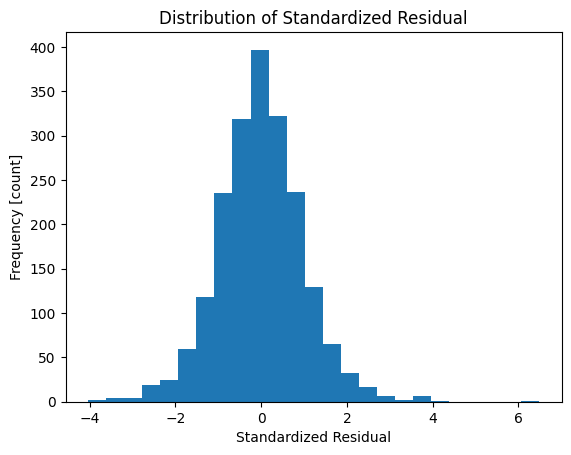

In [22]:
# Create histogram of standardized residuals, 25 bins
plt.hist(
    model.std_resid,
    bins = 25
)

# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residual");
plt.savefig("images/AMBUJA-Standardized-Residual-hist.png", dpi=150)

Our last visualization will the ACF of standardized residuals. Just like we did with our first ACF, we'll need to square the values here, too. 

**Task 8.3.18:** Create an ACF plot of the square of your standardized residuals. Don't forget axis labels!

- [What's an ACF plot?](../%40textbook/18-ts-models.ipynb#ACF-Plots)
- [Create an ACF plot using statsmodels.](../%40textbook/18-ts-models.ipynb#ACF-Plots)

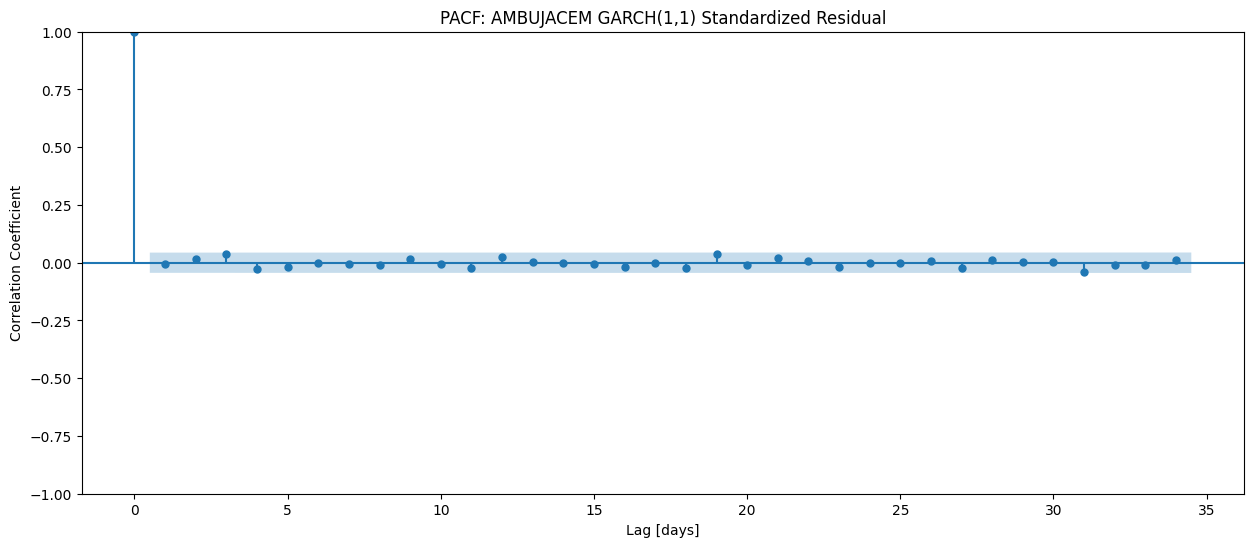

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid **2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("PACF: AMBUJACEM GARCH(1,1) Standardized Residual");
plt.savefig("images/AMBUJA-Standardized-Residual-pacf.png", dpi=150)

## Evaluate

To evaluate our model, we'll do walk-forward validation. Before we do, let's take a look at how this model returns its predictions.

**Task 8.3.19:** Create a one-day forecast from your `model` and assign the result to the variable `one_day_forecast`. 

- [What's variance?](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Generate a forecast for a model using arch.](../%40textbook/18-ts-models.ipynb#Forecasting)

In [24]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2021-11-22,3.642947


There are two things we need to keep in mind here. First, our `model` forecast shows the predicted **variance**, not the **standard deviation** / **volatility**. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The `"h.1"` column stands for "horizon 1", that is, our model's prediction for the following day. We'll have to keep all this in mind when we reformat this prediction to serve to the end user of our application.

**Task 8.3.20:** Complete the code below to do walk-forward validation on your `model`. Then run the following code block to visualize the model's test predictions.

- [What's walk-forward validation?](../%40textbook/17-ts-core.ipynb#Walk-Forward-Validation)
- [Perform walk-forward validation for time series model.](../%40textbook/17-ts-core.ipynb#Walk-Forward-Validation)

In [25]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_ambuja) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_ambuja.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(
        y_train,
        p = 1,
        q = 1,
        rescale = False
    ).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = np.sqrt(model.forecast(horizon=1, reindex=False).variance.iloc[0,0])

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.tail()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2023-11-22    1.380255
2023-11-23    1.424757
2023-11-24    1.392584
2023-11-28    1.371432
2023-11-29    1.857745
dtype: float64

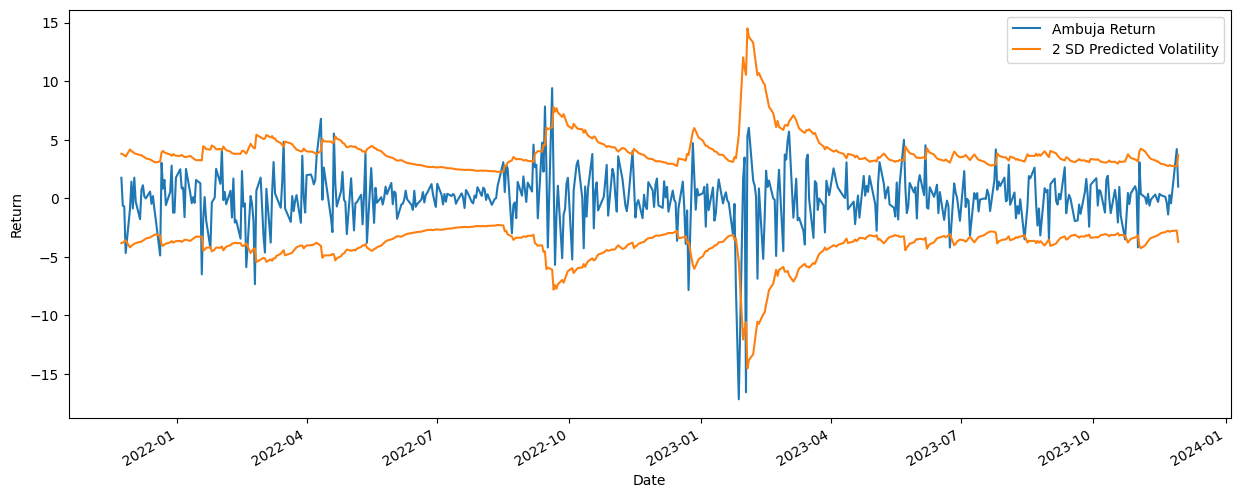

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_ambuja.tail(test_size).plot(ax=ax, label="Ambuja Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1", label = "")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time. This is especially clear in the low-volatility period in the summer of 2022 and the high-volatility period in fall 2022.

One additional step we could do to evaluate how our `model` performs on the test data would be to plot the ACF of the standardized residuals for only the test set. But you can do that step on your own.

# Communicate Results

Normally in this section, we create visualizations for a human audience, but our goal for *this* project is to create an API for a *computer* audience. So we'll focus on transforming our model's predictions to JSON format, which is what we'll use to send predictions in our application. 

The first thing we need to do is create a DatetimeIndex for our predictions. Using labels like `"h.1"`, `"h.2"`, etc., won't work. But there are two things we need to keep in mind. First, we can't include dates that are weekends because no trading happens on those days. And we'll need to write our dates using strings that follow the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) standard. 

**Task 8.3.21:** Below is a `prediction`, which contains a 5-day forecast from our `model`. Using it as a starting point, create a `prediction_index`. This should be a list with the following 5 dates written in ISO 8601 format.

- [Create a fixed frequency DatetimeIndex in pandas.](../%40textbook/04-pandas-advanced.ipynb#Date-Time-Indices)
- [Transform a Timestamp to ISO 8601 format in pandas.](../%40textbook/04-pandas-advanced.ipynb#Time-Stamps)

In [27]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days= 1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3      h.4       h.5
date                                                       
2023-11-28  1.857745  1.862296  1.866562  1.87056  1.874309
prediction_index type: <class 'list'>
prediction_index len: 5


['2023-11-29T00:00:00', '2023-11-30T00:00:00', '2023-12-01T00:00:00']

Now that we know how to create the index, let's create a function to combine the index and predictions, and then return a dictionary where each key is a date and each value is a predicted volatility. 

**Task 8.3.22:** Create a `clean_prediction` function. It should take a variance prediction DataFrame as input and return a dictionary where each key is a date in ISO 8601 format and each value is the predicted volatility. Use the docstring as a guide and the assert statements to test your function. When you're satisfied with the result, submit it to the grader.

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [Write a function in Python.](../%40textbook/02-python-advanced.ipynb#Functions)

In [28]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days= 1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [29]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2023-11-29T00:00:00': 1.8577450649810836,
 '2023-11-30T00:00:00': 1.86229630492677,
 '2023-12-01T00:00:00': 1.8665619011249688,
 '2023-12-04T00:00:00': 1.8705603947438423,
 '2023-12-05T00:00:00': 1.87430904690337,
 '2023-12-06T00:00:00': 1.8778239366796579,
 '2023-12-07T00:00:00': 1.8811200503938958,
 '2023-12-08T00:00:00': 1.8842113631114394,
 '2023-12-11T00:00:00': 1.8871109131598223,
 '2023-12-12T00:00:00': 1.8898308703748474}

Great work! We now have several components for our application: classes for getting data from an API, classes for storing it in a database, and code for building our model and cleaning our predictions. The next step is creating a class for our model and paths for application — both of which we'll do in the next lesson.

In [30]:
settings.model_directory

'models'

In [31]:
import os
import joblib
timestamp = pd.Timestamp.now().isoformat(timespec='minutes')
ticker = "SHOPERSTOP.BSE"
string = f"{ticker}.pkl"
filepath = os.path.join("models", string)
filepath

'models\\SHOPERSTOP.BSE.pkl'

In [32]:
joblib.dump(model, filepath)

['models\\SHOPERSTOP.BSE.pkl']